In [1]:
#You're gonna like this notebook if you want to brush up on SQL,get some tricks or want to revise certain procedures.
#You're gonna love this notebook if you like football.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline 


#The two research questions that I'll be concentrating on are:
# 1. How does Age of players correlate with Stamina, Reactions, Agility, Sprint Speed & Acceleration??
# 2. This is more Complex. I would like to find out which league is more unpredictable amongst
# EPL, Bundesliga, La Liga, Serie A and Ligue 1(Who watches anything else anyway?).
# For this I assign an Unpredictability score to every League. The steps to find this score is as follows:
#    a) Form league standings from match scores. [3 points to a team that wins, 0 for those who lose & 1 a piece if match ends in draw.]
#    b) Find out the Top 5 teams and the Bottom 5 of each league in each season.
#    c) Find out the results of the matches between the Top 5 and the Bottom 5 in that particular season
#    d) If any of the bottom 5 teams beat any of the Top 5 teams at their own home ground give them 1 point.
#       If they draw a match in their home ground give them 0.5 point.
#       If they manage to beat a Top 5 team away give them 1.25 points.
#       If they manage a draw with a Top 5 team away give them 0.75 points.
#       Add up all the scores for a season for each league and this is the Unpredictability of the league.

In [2]:
#connect connect connect let python meet SQL

connection = sqlite3.connect('database.sqlite')

#Every SQLite database has an SQLITE_MASTER table(read-only) that defines the schema for the database.
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""",connection)

In [3]:
#deal witht the biggest baddest table first and life is easier thereafter
#Do not be afraid of SELECT *... try it out... its harmless.....

#Q: Why do you never ask SQL people to help you move your furniture?
#A: They sometimes drop the tables

match = pd.read_sql("""SELECT *
                        FROM Match;
                        """, connection)
                       
print(match.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB
None


In [4]:
#they have an inbuilt for everything!!!!
match.isnull().sum(axis=0)

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
                    ...  
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD         

In [5]:
#drop 'em dead if they be NaN
match_imp = match.dropna(axis='columns')
print(match_imp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
id                  25979 non-null int64
country_id          25979 non-null int64
league_id           25979 non-null int64
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null object
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(9), object(2)
memory usage: 2.2+ MB
None


In [6]:
match_imp.duplicated().sum()

0

In [7]:
#merge Match Information with league information
match_league = pd.read_sql("""SELECT m.country_id,lg.name,m.season,m.stage,m.date,m.match_api_id,m.home_team_api_id,m.away_team_api_id,m.home_team_goal,m.away_team_goal
                              FROM match m
                              JOIN league lg
                              ON m.league_id = lg.id""",connection)
match_league.to_sql("match_league", connection, if_exists="replace")
print(match_league.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 10 columns):
country_id          25979 non-null int64
name                25979 non-null object
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null object
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(7), object(3)
memory usage: 2.0+ MB
None


In [8]:
#All this work to create standings tables
match_league['date'] = pd.to_datetime(match_league['date'])
match_league['winner'] = np.where(match_league['home_team_goal']> match_league['away_team_goal'],match_league['home_team_api_id'],match_league['away_team_api_id'])
match_league['winner'] = np.where(match_league['home_team_goal'] == match_league['away_team_goal'],999999,match_league['winner'])
match_league['draw1'] = np.where(match_league['home_team_goal'] == match_league['away_team_goal'],match_league['home_team_api_id'],999999)
match_league['draw2'] = np.where(match_league['home_team_goal'] == match_league['away_team_goal'],match_league['away_team_api_id'],999999)

match_league.to_sql("match_league", connection, if_exists="replace")
match_league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 13 columns):
country_id          25979 non-null int64
name                25979 non-null object
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null datetime64[ns]
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
winner              25979 non-null int64
draw1               25979 non-null int64
draw2               25979 non-null int64
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 2.6+ MB


In [9]:
#check out your work of art
query = pd.read_sql("""SELECT *
                       FROM match_league
                       ;""",connection)
query.head()

,index,country_id,name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,winner,draw1,draw2
0,0,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,999999,9987,9993
1,1,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,999999,10000,9994
2,2,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,8635,999999,999999
3,3,1,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,9991,999999,999999
4,4,1,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,9985,999999,999999


In [10]:
#All ze stats of da Teams
home_draw = pd.read_sql("""SELECT name,season,draw1,count(draw1) AS dh
                                   FROM match_league
                                   WHERE draw1 != 999999
                                   GROUP BY 1,2,3;""",connection)
away_draw = pd.read_sql("""SELECT name,season,draw2,count(draw2) AS da
                                   FROM match_league m1
                                   WHERE draw2 != 999999
                                   GROUP BY 1,2,3;""",connection)
winner_t = pd.read_sql("""SELECT name,season,winner,count(winner) AS w
                                   FROM match_league m1
                                   WHERE winner != 999999
                                   GROUP BY 1,2,3;""",connection)
home_draw.to_sql("home_draw", connection, if_exists="replace")
away_draw.to_sql("away_draw", connection, if_exists="replace")
winner_t.to_sql("winner_t", connection, if_exists="replace")

In [11]:
#Statz of da players
attribute = pd.read_sql("""SELECT pa.date,pl.birthday,pl.player_api_id,pl.player_name,pa.acceleration,pa.sprint_speed,pa.stamina,pa.agility,pa.reactions,pa.preferred_foot
                           FROM player pl
                           JOIN player_Attributes pa
                           ON pl.player_api_id = pa.player_api_id;""",connection)
attribute['date'] = pd.to_datetime(attribute['date'])
attribute['birthday'] = pd.to_datetime(attribute['birthday'])

attribute.to_sql("attribute_imp",connection,if_exists="replace")
attribute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 10 columns):
date              183978 non-null datetime64[ns]
birthday          183978 non-null datetime64[ns]
player_api_id     183978 non-null int64
player_name       183978 non-null object
acceleration      183142 non-null float64
sprint_speed      183142 non-null float64
stamina           183142 non-null float64
agility           181265 non-null float64
reactions         183142 non-null float64
preferred_foot    183142 non-null object
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 14.0+ MB


In [12]:
#Preparation of data is half the job
#Keeping most recent record of each player
attribute.drop_duplicates(subset=['player_api_id',],keep="first",inplace=True)
attribute.dropna(inplace=True)
attribute.to_sql("attribute_imp",connection,if_exists="replace")

In [13]:

#Calculate the age of player

def num_years(start,curr):
    return(int((curr-start).days / 365.25))

query = pd.read_sql("""SELECT * FROM attribute_imp;""",connection)
query['date'] = pd.to_datetime(query['date'])
query['birthday'] = pd.to_datetime(query['birthday'])
#query['age'] = (query['date'].dt.year)-(query['birthday'].dt.year)
query['age'] = query.apply(lambda x: num_years(x['birthday'], x['date']), axis = 1)

query.to_sql("attribute_imp",connection,if_exists="replace")

Text(0.5,1,'Correlation Matrix Between Age and Various Attributes')

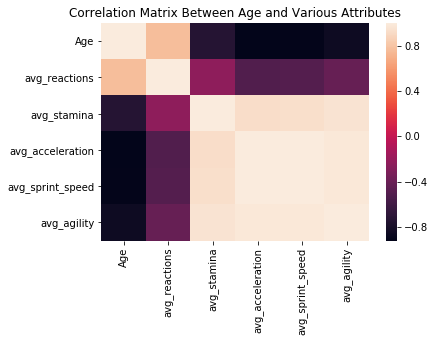

In [14]:
import seaborn as sns
query1 = pd.read_sql("""  SELECT age AS Age,AVG(reactions) AS avg_reactions,AVG(stamina) AS avg_stamina
                          ,AVG(acceleration) AS avg_acceleration,AVG(sprint_speed) AS avg_sprint_speed
                          ,AVG(agility) AS avg_agility
                          FROM attribute_imp
                          GROUP BY 1
                          ORDER BY 1""",connection)
corr = query1.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,)
ax.set_title("Correlation Matrix Between Age and Various Attributes")

This Correlation matrix helps us find out how different attributes are linked to each other. We can clearly see that Age has a strong negative correlation with average acceleration,average agility, average stamina and average sprint speed of the players whereas age shows a weak positive correlation with the average reactions of the players.

Text(0.5,1,'Overall vs Potential')

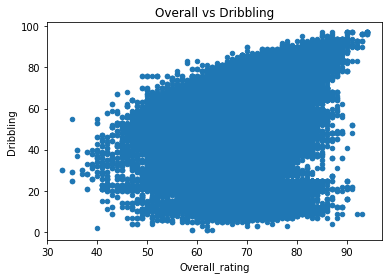

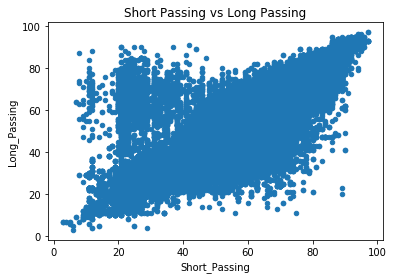

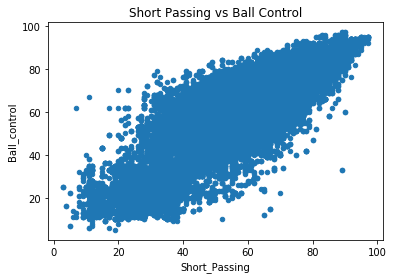

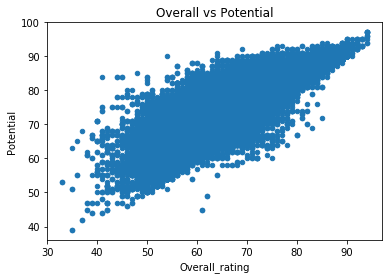

In [15]:
qu = pd.read_sql("""  SELECT overall_rating AS Overall_rating,potential AS Potential, dribbling AS Dribbling,
                        short_passing as Short_Passing, long_passing AS Long_Passing, ball_control AS Ball_control
                        FROM Player_Attributes
                        ORDER BY 1""",connection)

ax = qu.plot(x="Overall_rating",y="Dribbling",kind="scatter")
ax.set_title("Overall vs Dribbling")

ax = qu.plot(x="Short_Passing",y="Long_Passing",kind="scatter")
ax.set_title("Short Passing vs Long Passing")

ax = qu.plot(x="Short_Passing",y="Ball_control",kind="scatter")
ax.set_title("Short Passing vs Ball Control")

ax = qu.plot(x="Overall_rating",y="Potential",kind="scatter")
ax.set_title("Overall vs Potential")

In this section I have displayed various scatter plots between attributes that I thought might have links with each other. In terms of prediction analysis later we might infer that ball control and short passing form a good fit.

Players with higher overall ratings are not always the players who can dribble well and this is true as several high rated players are defenders and goalkeepers whose strong suit is not dribbling.

Surprisingly there are a lot of players who despite having high Long Passing scores have low Short Passing scores and this is a very interesting point

Correlation of Reactions with Age:  0.7675305570880387
Correlation of Stamina with Age:  -0.7260835589278937
Correlation of Acceleration with Age:  -0.9199811468752116
Correlation of Sprint Speed with Age:  -0.9104739545625228
Correlation of Agility with Age:  -0.849583392075151


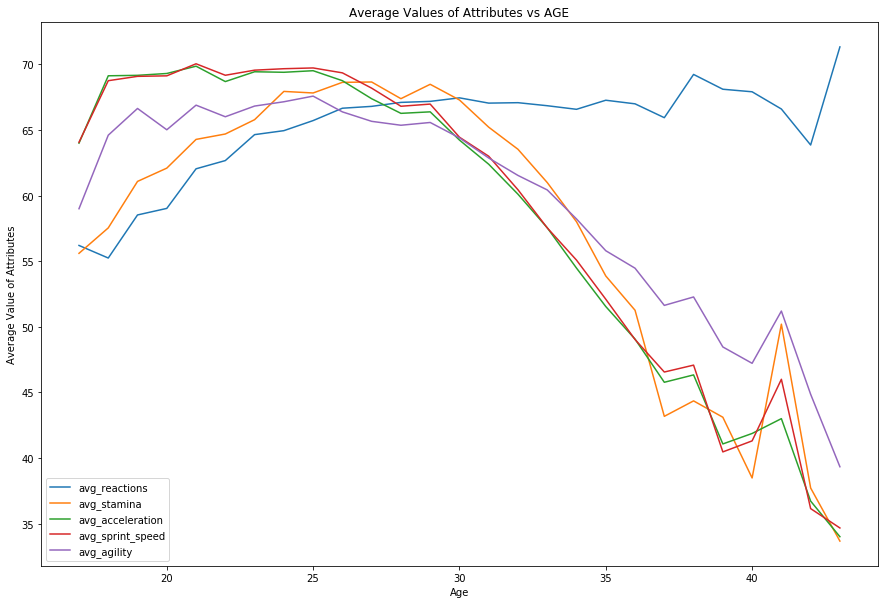

In [16]:
#This is where we plot
query1 = pd.read_sql("""  SELECT age AS Age,AVG(reactions) AS avg_reactions,AVG(stamina) AS avg_stamina
                          ,AVG(acceleration) AS avg_acceleration,AVG(sprint_speed) AS avg_sprint_speed
                          ,AVG(agility) AS avg_agility
                          FROM attribute_imp
                          GROUP BY 1
                          ORDER BY 1""",connection)
ax = query1.plot(x="Age", y=["avg_reactions", "avg_stamina", "avg_acceleration","avg_sprint_speed","avg_agility"], kind="line",figsize=(15,10))

ax.set_ylabel("Average Value of Attributes")
ax.set_title("Average Values of Attributes vs AGE")
print("Correlation of Reactions with Age: ",query1['Age'].corr(query1['avg_reactions']))
print("Correlation of Stamina with Age: ",query1['Age'].corr(query1['avg_stamina']))
print("Correlation of Acceleration with Age: ",query1['Age'].corr(query1['avg_acceleration']))
print("Correlation of Sprint Speed with Age: ",query1['Age'].corr(query1['avg_sprint_speed']))
print("Correlation of Agility with Age: ",query1['Age'].corr(query1['avg_agility']))

,Preferred_Foot,Number_of_Players
0,left,2583
1,right,7999


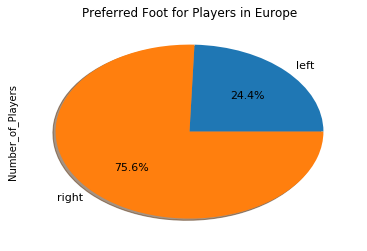

In [17]:
query = pd.read_sql("""SELECT preferred_foot AS Preferred_Foot,COUNT(*) as Number_of_Players 
                        FROM attribute_imp
                        GROUP BY 1""",connection)




ax = query.plot(kind="pie",y='Number_of_Players', autopct='%1.1f%%',
 startangle=0, shadow=True, labels=query['Preferred_Foot'], legend = False, fontsize=11)


ax.set_title("Preferred Foot for Players in Europe")
query

In [18]:
#Forming league Tables
query = pd.read_sql("""SELECT hd.name,hd.season,hd.draw1 AS Team_id,hd.dh+ad.da+3*wi.w AS Points
                       FROM home_draw hd
                       JOIN away_draw ad
                       ON hd.name = ad.name AND hd.season=ad.season AND hd.draw1=ad.draw2
                       JOIN winner_t wi
                       ON hd.name = wi.name AND hd.season=wi.season AND hd.draw1 = wi.winner
                       WHERE hd.name LIKE "England Premier League" OR hd.name LIKE "France Ligue 1" OR 
                       hd.name LIKE "Germany 1. Bundesliga" OR hd.name LIKE "Italy Serie A" OR
                       hd.name LIKE "Spain LIGA BBVA" 
                       ORDER BY 1,2,4 DESC;""",connection)
query.to_sql("league_tables",connection,if_exists="replace")

In [19]:
#To find Top 5 and Bottom 5 of each league in each season
query = pd.read_sql("""SELECT * FROM league_tables;""",connection)
lar = (query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nlargest(5,'Points'))
sma=(query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nsmallest(5,'Points'))

In [20]:
#To find Top 5 and Bottom 5 of each league in each season
### SQL APPROACH USING SQLITE syntax(due to Pandas adhering to that) i.e. solve this SELF JOIN in stead of OVER

#query = pd.read_sql("""SELECT * 
#                       FROM test t1 
#                       WHERE
#                           (SELECT count(*) 
#                             FROM test t2 
#                             WHERE t2.name = t1.name and t2.season = t1.season and t2.Points >= t1.points ) <= 5 
#                       ORDER BY name, season, points desc""")

In [21]:
#Evaluating head-to-head scores to find the Unpredictability of each league
query = pd.read_sql("""SELECT * FROM league_tables;""",connection)
lar = (query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nlargest(5,'Points'))

sma=(query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nsmallest(5,'Points'))

query1 = pd.read_sql("""SELECT * FROM match_league
                        WHERE name IN ("France Ligue 1","England Premier League","Spain LIGA BBVA","Germany 1. Bundesliga","Italy Serie A")
                        ORDER BY name,date;""",connection)
l=0

c=[0]*40
ss = []
for k in range(0,200,5):
    for i in range(k,k+5):
        for j in range(k,k+5):
            sid = sma.iloc[i,3] #Team_id of one of the Bottom 5
            lid = lar.iloc[j,3] #Team_id of one of the Top 5
            s=sma.iloc[i,2]     #Season for which we are evaluating
            ss.append(s)
            #When bottom 5 teams plays the Top 5 teams at their home
            a = query1.loc[query1.home_team_api_id == sid] #Filtering by home team
            b = a.loc[(query1.away_team_api_id == lid)]    #Filtering by away team
            d = b.loc[(query1.season == s)]                #Filtering by season
           
            if((not d.empty)):
                if((d.iloc[0,11]==sid)):
                    c[l] = c[l] + 1
                elif((d.iloc[0,11]==999999)):
                    c[l] = c[l] + 0.5
                
            #When bottom 5 teams plays the Top 5 teams away
            a = query1.loc[query1.home_team_api_id == lid]
            b = a.loc[(query1.away_team_api_id == sid)]
            d = b.loc[(query1.season == s)]
            if((not d.empty)):
                if((d.iloc[0,11]==sid)):
                    c[l] = c[l] + 1.25
                elif((d.iloc[0,11]==999999)):
                    c[l] = c[l] + 0.5
            
            
    l=l+1

Average Unpredictability: 
 English Premier League     9.50000
France Ligue 1            11.40625
Germany 1. Bundesliga     10.50000
Italy Serie A              9.65625
Spain LIGA BBVA            9.78125
dtype: float64


,English Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Spain LIGA BBVA
2008/2009,7.75,11.50,10.25,9.50,14.00
2009/2010,9.50,10.50,9.75,9.25,10.50
2010/2011,11.75,11.25,14.50,11.75,15.75
2011/2012,7.75,13.50,10.25,8.50,8.00
2012/2013,13.00,13.25,8.75,6.25,8.00
2013/2014,7.00,9.50,10.75,10.75,7.50
2014/2015,8.75,8.25,10.50,12.00,6.00
2015/2016,10.50,13.50,9.25,9.25,8.50


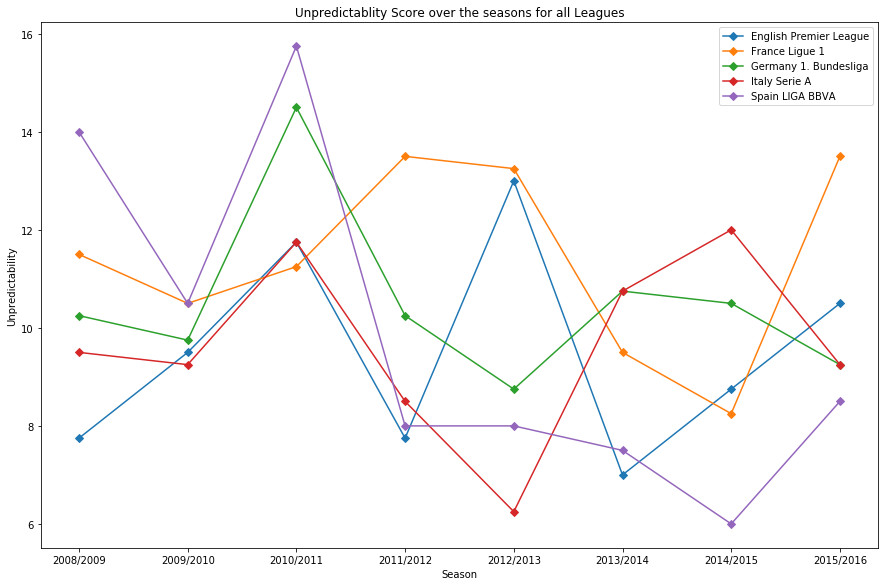

In [22]:
from collections import OrderedDict
a=list(OrderedDict.fromkeys(ss))
df = {'English Premier League':pd.Series(data=c[0:8],index=a),
      'France Ligue 1':pd.Series(data=c[8:16],index=a),
      'Germany 1. Bundesliga':pd.Series(data=c[16:24],index=a),
      'Italy Serie A':pd.Series(data=c[24:32],index=a),
      'Spain LIGA BBVA':pd.Series(data=c[32:40],index=a)}
df=pd.DataFrame(df)
ax = df.plot(figsize=(15,10),marker='D')
ax.set_xlabel("Season")
ax.set_ylabel("Unpredictability")
ax.set_title("Unpredictablity Score over the seasons for all Leagues")
x= [0, 1, 2, 3, 4, 5, 6, 7]
labels =['2008/2009','2009/2010','2010/2011','2011/2012','2012/2013','2013/2014','2014/2015','2015/2016']
plt.xticks(x,labels)
plt.subplots_adjust(bottom=0.15)
print("Average Unpredictability: \n",df.mean(axis=0))
df

,name,HOME,AWAY
0,England Premier League,4715,3525
1,France Ligue 1,4265,3162
2,Germany 1. Bundesliga,3982,3121
3,Italy Serie A,4528,3367
4,Spain LIGA BBVA,4959,3453


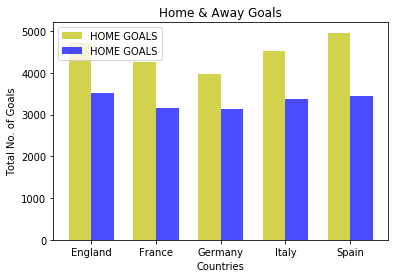

In [23]:
query = pd.read_sql("""SELECT name,SUM(home_team_goal) as HOME,SUM(away_team_goal) AS AWAY
                        FROM match_league
                        WHERE name IN ("France Ligue 1","England Premier League","Spain LIGA BBVA","Germany 1. Bundesliga","Italy Serie A")
                        GROUP BY 1""",connection)

ind = np.arange(5)
width = 0.35

hm = plt.bar(ind, query['HOME'],width,color='y',alpha=0.7,label='HOME GOALS')
aw = plt.bar(ind+width, query['AWAY'],width,color='b',alpha=0.7,label='HOME GOALS')
plt.ylabel('Total No. of Goals')
plt.xlabel('Countries')
plt.title('Home & Away Goals')
locations = ind+width / 2
labels = ["England","France","Germany","Italy","Spain"]
plt.xticks(locations,labels)
plt.legend()
query

In [24]:
query = pd.read_sql("""SELECT player_api_id
                        FROM player_attributes
                        WHERE (long_passing>85) and (short_passing<15)""",connection)
query

,player_api_id
0,24494
1,27697


,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
buildUpPlaySpeed,1.000000,0.041926,0.224527,0.308168,0.094170,0.095448,-0.190411,0.089650,-0.054177
buildUpPlayDribbling,0.041926,1.000000,-0.135027,0.021167,0.101190,0.099434,-0.057030,-0.036704,0.144537
buildUpPlayPassing,0.224527,-0.135027,1.000000,0.214923,0.220470,0.021519,-0.213262,-0.102824,-0.005014
chanceCreationPassing,0.308168,0.021167,0.214923,1.000000,0.297821,0.153480,0.097371,0.103659,0.072126
chanceCreationCrossing,0.094170,0.101190,0.220470,0.297821,1.000000,-0.067472,0.082154,0.037898,0.149792
chanceCreationShooting,0.095448,0.099434,0.021519,0.153480,-0.067472,1.000000,0.051954,0.122866,0.095715
defencePressure,-0.190411,-0.057030,-0.213262,0.097371,0.082154,0.051954,1.000000,0.436227,0.334042
defenceAggression,0.089650,-0.036704,-0.102824,0.103659,0.037898,0.122866,0.436227,1.000000,0.086278
defenceTeamWidth,-0.054177,0.144537,-0.005014,0.072126,0.149792,0.095715,0.334042,0.086278,1.000000


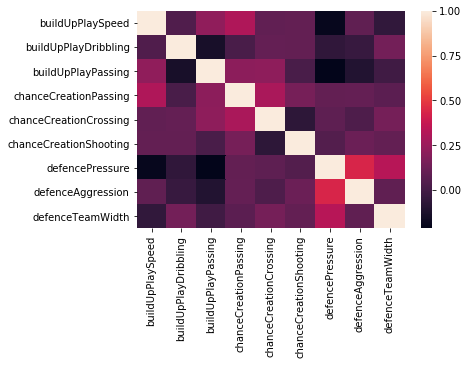

In [25]:
import seaborn as sns
query1 = pd.read_sql(""" SELECT * FROM Team_Attributes;""",connection)
query1.drop_duplicates(subset=['team_api_id',],keep="last",inplace=True)
query1.dropna(inplace=True)

query1.drop(['id','team_api_id','team_fifa_api_id'],axis=1,inplace=True)
corr = query1.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,)
corr

In [26]:
query = pd.read_sql("""SELECT * FROM league_tables;""",connection)
lar = (query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nlargest(5,'Points'))
sma=(query.groupby(['name','season'],group_keys=False)).apply(lambda x: x.nsmallest(5,'Points'))

lar.to_sql("top_teams",connection,if_exists="replace")
sma.to_sql("bottom_teams",connection,if_exists="replace")

,Team_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
Team_id,1.000000,-0.250212,0.009046,-0.103029,-0.132435,0.020501,-0.093685,-0.082604,-0.235655,-0.156068
buildUpPlaySpeed,-0.250212,1.000000,0.000256,0.356335,0.271060,0.248865,0.165148,-0.154096,0.149654,-0.186901
buildUpPlayDribbling,0.009046,0.000256,1.000000,0.095492,0.250461,0.217277,0.100975,-0.089749,-0.229192,0.058084
buildUpPlayPassing,-0.103029,0.356335,0.095492,1.000000,0.266928,0.402928,0.074793,-0.124527,-0.052160,0.211757
chanceCreationPassing,-0.132435,0.271060,0.250461,0.266928,1.000000,0.418667,0.366746,0.076841,0.289263,-0.142000
chanceCreationCrossing,0.020501,0.248865,0.217277,0.402928,0.418667,1.000000,0.096994,-0.062433,-0.102750,0.092390
chanceCreationShooting,-0.093685,0.165148,0.100975,0.074793,0.366746,0.096994,1.000000,-0.046234,0.270918,-0.154875
defencePressure,-0.082604,-0.154096,-0.089749,-0.124527,0.076841,-0.062433,-0.046234,1.000000,0.310743,0.322512
defenceAggression,-0.235655,0.149654,-0.229192,-0.052160,0.289263,-0.102750,0.270918,0.310743,1.000000,-0.095188
defenceTeamWidth,-0.156068,-0.186901,0.058084,0.211757,-0.142000,0.092390,-0.154875,0.322512,-0.095188,1.000000


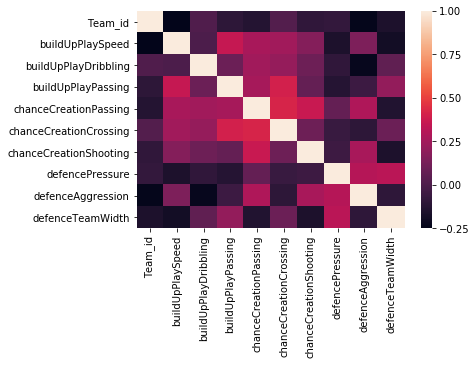

In [27]:
query = pd.read_sql("""SELECT tp.Team_id,ta.buildUpPlaySpeed, ta.buildUpPlayDribbling,ta.buildUpPlayPassing, ta.chanceCreationPassing,
                              ta.chanceCreationCrossing, ta.chanceCreationShooting, ta.defencePressure, ta.defenceAggression, ta.defenceTeamWidth
                              
                        FROM top_teams tp
                        JOIN Team_Attributes ta
                        ON tp.Team_id = ta.team_api_id;""",connection)
query.dropna(inplace=True)
query.drop_duplicates(subset=['Team_id',],keep="last",inplace=True)
corr = query.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,)
corr

,Team_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
Team_id,1.000000,0.198624,-0.047098,0.110351,0.141142,-0.177328,-0.060931,-0.163041,0.094610,-0.137373
buildUpPlaySpeed,0.198624,1.000000,0.003092,0.241157,0.258670,0.079392,0.060156,-0.218705,0.017667,-0.169604
buildUpPlayDribbling,-0.047098,0.003092,1.000000,-0.189952,-0.100440,0.041266,-0.036427,-0.007714,0.054012,0.067166
buildUpPlayPassing,0.110351,0.241157,-0.189952,1.000000,0.348211,0.213442,-0.014544,-0.187025,-0.242950,0.074978
chanceCreationPassing,0.141142,0.258670,-0.100440,0.348211,1.000000,0.311002,0.053611,0.241265,-0.040432,0.070156
chanceCreationCrossing,-0.177328,0.079392,0.041266,0.213442,0.311002,1.000000,-0.179887,0.167048,0.006809,0.048797
chanceCreationShooting,-0.060931,0.060156,-0.036427,-0.014544,0.053611,-0.179887,1.000000,0.016190,-0.049673,0.109003
defencePressure,-0.163041,-0.218705,-0.007714,-0.187025,0.241265,0.167048,0.016190,1.000000,0.256296,0.349493
defenceAggression,0.094610,0.017667,0.054012,-0.242950,-0.040432,0.006809,-0.049673,0.256296,1.000000,-0.009973
defenceTeamWidth,-0.137373,-0.169604,0.067166,0.074978,0.070156,0.048797,0.109003,0.349493,-0.009973,1.000000


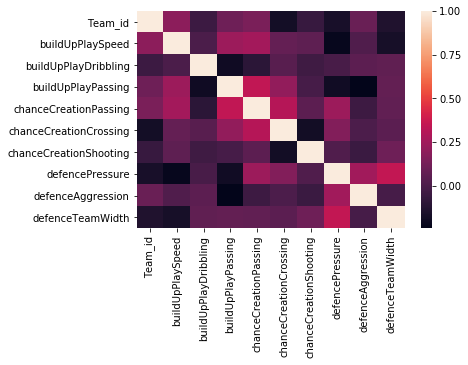

In [28]:
query = pd.read_sql("""SELECT tp.Team_id,ta.buildUpPlaySpeed, ta.buildUpPlayDribbling,ta.buildUpPlayPassing, ta.chanceCreationPassing,
                              ta.chanceCreationCrossing, ta.chanceCreationShooting, ta.defencePressure, ta.defenceAggression, ta.defenceTeamWidth
                              
                        FROM bottom_teams tp
                        JOIN Team_Attributes ta
                        ON tp.Team_id = ta.team_api_id;""",connection)
query.dropna(inplace=True)
query.drop_duplicates(subset=['Team_id',],keep="last",inplace=True)
corr = query.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,)
corr